In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd  
from IPython.display import display_html
from numpy.random import rand

newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [2]:
class Variables(object): 
    def __init__(self, alpha=1, b=2, c=5, exSol=0, func=0):
        self.alpha = alpha
        self.b = b
        self.c = c
        self.exSol = exSol 
        self.func = func # rhs

In [15]:
# Help functions to use throughout the project
def loc2glob(k,gamma):
    return k+gamma          # Numbering k from 0

def Ak(hi, Var): # Stiffness matrix blocks
    A = (   (Var.alpha/hi)*np.array([[1,-1],
                                     [-1,1]]) +  
            (Var.b/2)*np.array([[-1,1],
                                [-1,1]]) +  
            (Var.c*hi/6)*np.array([[ 2,1],
                                   [1,2]]))
    return A

def Fk(hi, k, Var,T): # Load Vector
    fk = (hi/2)*np.array([Var.func(T[k][0], Var),Var.func(T[k][1], Var)])   
    return fk

def convergence(Var, solver, sqr=False, saveas = 0, lab = 0, bound = 0): 
    P = 10                           # Number of refinements
    M = 20                          # Initial number of elements
    Hconv = np.zeros(P)             # Mesh size
    EL2 = np.zeros(P)               # To store L2 error
    EH1 = np.zeros(P)               # To store H1 error
    x_interp = np.linspace(0,1,500) # Fine mesh for interpolated solution

    if sqr == True:                 # Adds the value when considering the discontinuous case
        root = np.sqrt(2) / 2
        x_interp = np.append(x_interp, root)
        x_interp = np.sort(x_interp)
        
    exact = Var.exSol(x_interp)         # Exact solution  
    
    for p in range(P):                  # Refinement loop
        x_cord = np.linspace(0,1,M)     # Mesh
        if sqr == True:                 # Adds the value when considering the discontinuous case
            root = np.sqrt(2) / 2
            x_cord = np.append(x_cord, root)
            x_cord = np.sort(x_cord)

        Hconv[p] = x_cord[1]-x_cord[0]  # Mesh size
        U = solver(Var, x_cord)         # Numerical solution

        u_interp = sp.interpolate.interp1d(x_cord, U, kind = "linear")    # Interpolated numerical solution
        err = exact-u_interp(x_interp)                                    # Error difference

        EL2[p] = np.sqrt(sp.integrate.trapezoid(err**2,x_interp))                             # L2 norm, numerical integration
        grad_norm = np.sqrt(sp.integrate.trapezoid(np.gradient(err, x_interp)**2, x_interp))  # Gradient norm
        EH1[p] = np.sqrt(EL2[p]**2 + grad_norm**2)                                            # H1 norm of the error

        M += 5

    # Calculate the convergence rates
    orderL2 = np.polyfit(np.log(Hconv),np.log(EL2),1)[0]
    orderH1 = np.polyfit(np.log(Hconv),np.log(EH1),1)[0]

    RateL2=np.zeros(np.size(EL2))
    RateH1=np.zeros(np.size(EH1))

    RateL2[1:]=np.log10(EL2[1:]/EL2[:-1])/np.log10(Hconv[1:]/Hconv[:-1])
    RateH1[1:]=np.log10(EH1[1:]/EH1[:-1])/np.log10(Hconv[1:]/Hconv[:-1])

    # Create dataframes for the convergence rates
    pd.options.display.float_format = '{:.5f}'.format
    dfL2 = pd.DataFrame(data={'h': Hconv, 'Error L2': EL2 ,'Rate L2':RateL2})
    dfH1 = pd.DataFrame(data={'h': Hconv,'Error H1': EH1 ,'Rate H1':RateH1})

    # Print the dataframes and the convergence rates
    plot_conv_and_exact(Var, x_interp, exact, x_cord, U, Hconv, EL2, EH1, orderL2, orderH1, lab = lab, bound = bound, saveas = saveas)
    plot_dataframes(dfL2,dfH1)

def plot_conv_and_exact(Var, x_exact, u_exact, x_cord, U, Hconv, EL2, EH1, orderL2, orderH1,  lab, bound, saveas = 0):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(r"" + f"α={Var.alpha}, b={Var.b}, c={Var.c}")

    ax[0].set_title("Solutions")
    ax[0].plot(x_exact, u_exact, label="Exact", color='dodgerblue')
    ax[0].plot(x_cord, U, '.', label="Numerical", markersize=4, color='red')
    ax[0].set_xlabel("x")
    ax[0].set_ylabel(lab)
    ax[0].set_facecolor("whitesmoke")
    ax[0].legend(loc=1)

    ax[1].set_title("Convergence")
    if bound != 0:
        ax[1].loglog(Hconv, 2*Hconv, "o-", label="$H^1$ Err. bound", color='black')
    ax[1].loglog(Hconv, EL2, "o-", label=rf"$L^2$: p = {orderL2:.2}", color='mediumturquoise')
    ax[1].loglog(Hconv, EH1, "o-", label=rf"$H^1$: p = {orderH1:.2}", color='blueviolet')
    ax[1].set_xlabel("h")
    ax[1].set_ylabel("Error")
    ax[1].legend(loc=4)
    ax[1].set_facecolor("whitesmoke")
    plt.tight_layout()

    if saveas != 0:
        plt.savefig(saveas + ".png")

    plt.show()

def plot_exact(Var, x_exact, x_cord, U, saveas = 0):
    ax = plt.axes()
    ax.set_facecolor("whitesmoke")
    plt.plot(x_exact,Var.exSol(x_exact), color='dodgerblue')
    plt.plot(x_cord,U, 'o', color='red')
    plt.legend(['Numerical','Exact'])
    plt.xlabel('x')
    plt.ylabel('$u(x)$')
    if saveas != 0:
        plt.savefig(saveas + ".png")
    plt.show()
    
def plot_dataframes(df1,df2=0):
    html_str = ''
    if type(df2) == int:
        html_str = df1.to_html()
    else:
        html_str = df1.to_html() + df2.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-right:20px;"'), raw=True)

def irreg_plots(Var, solver, sing_ref_x, n, saveas = 0):
    P = 7                # Number of refinements
    r = 0.3              # Initial irregularity parameter

    EL2irr = np.zeros(P)    # To store L2 error, irregular
    EH1irr = np.zeros(P)    # To store H1 error, irregular
    R = np.zeros(P)         # Irregularity parameter

    x_interp = np.linspace(0,1,500) # Fine mesh for interpolated solution
    U_corr = solver(Var, x_interp)
    
    for p in range(P):                  # Iterating over r-s
        R[p] = r
        sing_x = sing_ref_x(n, r)
        U_sing = solver(Var, sing_x)    # Numerical solution

        sing_interp = sp.interpolate.interp1d(sing_x, U_sing, kind = "linear")    # Interpolated numerical solution
        sing_err = np.abs(U_corr-sing_interp(x_interp))                           # Error, irregular

        EL2irr[p] = np.sqrt(sp.integrate.trapezoid(sing_err**2,x_interp))                          # L2 norm, numerical integration
        grad_norm = np.sqrt(sp.integrate.trapezoid(np.gradient(sing_err, x_interp)**2, x_interp))  # Gradient norm
        EH1irr[p] = np.sqrt(EL2irr[p]**2 + grad_norm**2)                                           # H1 norm of the error
        
        r += 0.1

    equi_x = np.linspace(0,1,n)     # Equidistant mesh
    U_equi = solver(Var, equi_x)    # Numerical solution, equidistant
    equi_interp = sp.interpolate.interp1d(equi_x, U_equi, kind = "linear")    # Interpolated numerical solution
    equi_err = np.abs(U_corr-equi_interp(x_interp))                           # Error, equidistant
     
    EL2equi = np.sqrt(sp.integrate.trapezoid(equi_err**2,x_interp))                            # L2 norm, numerical integration
    grad_norm = np.sqrt(sp.integrate.trapezoid(np.gradient(equi_err, x_interp)**2, x_interp))  # Gradient norm
    EH1equi = np.sqrt(EL2equi**2 + grad_norm**2)                                               # H1 norm of the error
    EEqui = np.array([EL2equi, EH1equi])    
    err_type = ['L2', 'H1']

    # Create dataframes for the errors
    pd.options.display.float_format = '{:.5f}'.format
    dfL2irr = pd.DataFrame(data={'r': R, 'Error L2': EL2irr})
    dfH1irr = pd.DataFrame(data={'r': R,'Error H1': EH1irr})
    dfequi = pd.DataFrame(data={'n': n, 'Error': EEqui, 'Type': err_type})

    # Print the dataframes and the convergence rates
    plot_exact_d(Var, x_interp, U_corr, sing_x, equi_x, U_sing, U_equi,r-0.1, n, saveas=saveas) # minus 0.1 to get the last r-value
    print("Graded")
    plot_dataframes(dfL2irr,dfH1irr)
    print("Equidistant")
    plot_dataframes(dfequi)

def plot_exact_d(Var, x_exact, u_exact, sing_x, equi_x, U_sing, U_equi, r, n, saveas = 0):
    ax = plt.axes()
    ax.set_facecolor("whitesmoke")
    plt.title(f"α={Var.alpha}, b={Var.b}, c={Var.c}, r = {r:.1f}, n = {n}")
    plt.plot(x_exact, u_exact, label="Exact solution", color='black')
    plt.plot(sing_x, U_sing, '.', label="Graded", color='red')
    plt.plot(equi_x, U_equi, '.', label="Equidistant", color='dodgerblue')
    plt.xlabel("x")
    plt.ylabel("Approx. $u(x)$")
    plt.legend(loc='lower center')
    plt.tight_layout()

    if saveas != 0:
        plt.savefig(saveas + ".png")
    plt.show()


In [4]:
def FEM(Var, x, print_stiff_mat=False):
    Mi = len(x) # Number of nodes
    Mk = Mi-1   # Number of elements

    T = np.ndarray.transpose(np.array([x[:-1],x[1:]])) # Set of elements/triangulation
    H = x[1:]-x[:-1]  # Element sizes
    
    A = np.zeros((Mi,Mi)) #Stiffnes matrix
    F = np.zeros((Mi))    #Load vector
    U = np.zeros(Mi)      #Numerical Solution
    
    for k in range(0,Mk):                           # Loop over all elements K_i
        for gamma in range(2):                      # Loop over local nodes, in element matrices
            i = loc2glob(k,gamma)                   # Global node number computed from local node number
            for beta in range(2):                   # Loop over local nodes
                j = loc2glob(k,beta)                # Global node number
                A[i,j] += Ak(H[k], Var)[gamma,beta] # Evaluates matrix at current stepsize, chooses correct element
            F[i] += Fk(H[k],k, Var, T)[gamma]       # Assembly of global vector

    U[1:-1] = np.linalg.solve(A[1:-1,1:-1],F[1:-1])

    if print_stiff_mat: print("A=\n", np.around(A,decimals=1, out=None),"\n\n","F=", np.around(F,decimals=1, out=None))
    return U

In [5]:
def f1(x, Var): # Solved with alpha = 1, b = 2, c = 5
    return -5*x**2 + x + 4

def u(x):
    return x*(1-x)

A=
 [[  9.2  -8.9   0.    0.    0.    0.    0.    0.    0.    0. ]
 [-10.9  20.3  -8.9   0.    0.    0.    0.    0.    0.    0. ]
 [  0.  -10.9  20.3  -8.9   0.    0.    0.    0.    0.    0. ]
 [  0.    0.  -10.9  14.   -2.1   0.    0.    0.    0.    0. ]
 [  0.    0.    0.   -4.1   9.2  -3.8   0.    0.    0.    0. ]
 [  0.    0.    0.    0.   -5.8  15.5  -8.9   0.    0.    0. ]
 [  0.    0.    0.    0.    0.  -10.9  30.3 -19.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.  -21.   70.1 -49.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.  -51.   83.4 -32.3]
 [  0.    0.    0.    0.    0.    0.    0.    0.  -34.3  34.4]] 

 F= [0.2 0.4 0.4 0.8 0.7 0.2 0.1 0.  0.  0. ]


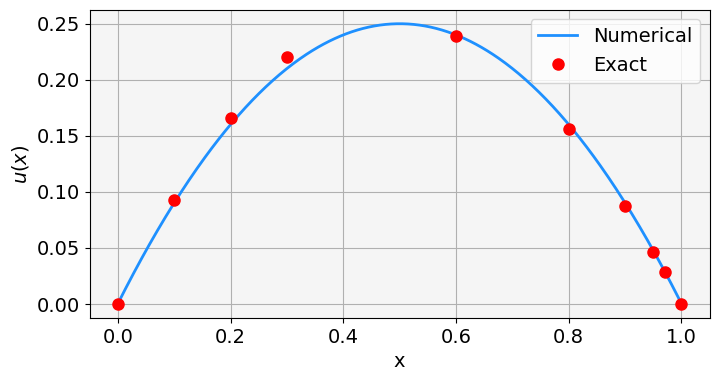

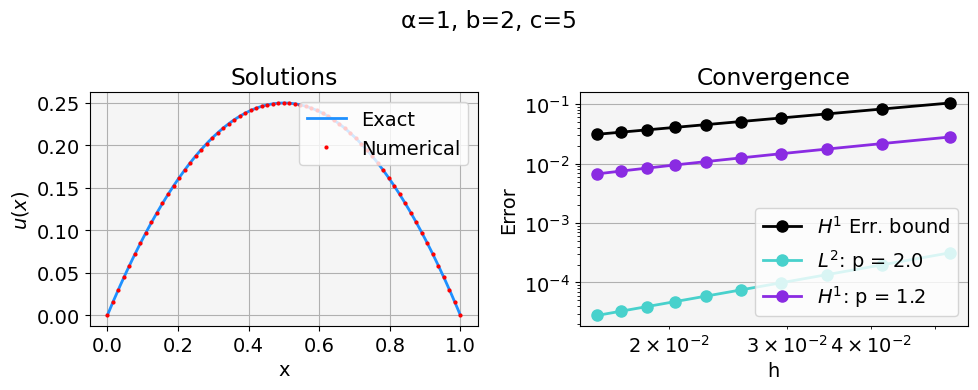

,h,Error L2,Rate L2
0,0.05263,0.00032,0.00000
1,0.04167,0.00020,2.00212
2,0.03448,0.00014,2.00142
3,0.02941,0.00010,2.00138
4,0.02564,0.00008,2.00039
5,0.02273,0.00006,2.00154
6,0.02041,0.00005,1.99915
7,0.01852,0.00004,2.00049
8,0.01695,0.00003,2.00014
9,0.01562,0.00003,2.00160


In [6]:
Var = Variables(alpha=1, b=2, c=5, exSol=u,  func=f1)
Xk= np.array([0, 0.1, 0.2, 0.3, 0.6, 0.8, 0.9, 0.95, 0.97, 1])

U = FEM(Var, Xk, print_stiff_mat=True)

plot_exact(Var, np.linspace(0,1,500), Xk, U)
convergence(Var, FEM, saveas= "2b", lab = "$u(x)$", bound = True)

In [7]:
def w1(x):
    return np.where(x <= np.sqrt(2)/2, 2*x/np.sqrt(2), (1-x)/(1-np.sqrt(2)/2))

def dw1(x):
    return np.where(x <= np.sqrt(2)/2, 2/np.sqrt(2), (-x)/(1-np.sqrt(2)/2))
    
def w2(x):
    return x-x**(3/4)

def dw2(x):
    return 1-(3/4)*x**(-1/4)

In [8]:
def FEM_non_smooth_w2(Var, x, print_stiff_mat=False):
    Mi = len(x) # Number of nodes
    Mk = Mi-1   # Number of elements
    H = np.diff(x)  # Element sizes

    A = np.zeros((Mi,Mi))   #Stiffnes matrix
    F = np.zeros((Mi))      #Load vector
    U = np.zeros(Mi)        #Numerical Solution

    hat_func = lambda gamma: -1 if gamma == 0 else 1    

    integral_ab = lambda x0, x1, alpha, b, h: alpha*(x1-x1**(3/4))/h - b*(0.5*x1**2 - (4/7)*x1**(7/4))/h - (alpha*(x0-x0**(3/4))/h - b*(0.5*x0**2 - (4/7)*x0**(7/4))/h) #
    
    integral_c = lambda x0, x1, c, h: (c/h)*((1/3)*x1**3 - (4/11)*x1**(11/4) - (x0/2)*x1**2 + (4*x0/7)*x1**(7/4) -
                                             ((1/3)*x0**3 - (4/11)*x0**(11/4) - (1/2)*x0**3 + (4/7)*x0**(11/4)))

    for k in range(0,Mk):                           # Loop over all elements K_i
        for gamma in range(2):                      # Loop over local nodes, in element matrices
            i = loc2glob(k,gamma)                   # Global node number computed from local node number
            for beta in range(2):                   # Loop over local nodes
                j = loc2glob(k,beta)                # Global node number
                A[i,j] += Ak(H[k], Var)[gamma,beta] # Evaluates matrix at current stepsize, chooses correct element
            F[i] += hat_func(gamma)*integral_ab(x[k], x[k+1], Var.alpha, Var.b, H[k]) # Assembly of load vector
            if gamma == 0:                                      # If gamma is 0, the integral is computed from x[k] to x[k+1]
                F[i] +=  integral_c(x[k], x[k+1], Var.c, H[k])
            else:                                               # If gamma is 1, the integral is computed from x[k+1] to x[k]     
                F[i] += integral_c(x[k+1], x[k], Var.c, H[k])

    U[1:-1] = np.linalg.solve(A[1:-1,1:-1],F[1:-1])

    if print_stiff_mat: print("A=\n", np.around(A,decimals=1, out=None),"\n\n","f=", np.around(f,decimals=1, out=None))
    return U

In [9]:
def FEM_non_smooth_w1(Var, x, print_stiff_mat=False):
    Mi = len(x) # Number of nodes
    Mk = Mi-1   # Number of elements
    H = np.diff(x)  # Element sizes

    A = np.zeros((Mi,Mi))   #Stiffnes matrix
    F = np.zeros((Mi))      #Load vector
    U = np.zeros(Mi)        #Numerical Solution

    hat_func = lambda gamma: -1 if gamma == 0 else 1    

    ###----- Integrals for the interval where x =< sqrt(2)/2 -----
    integral_a_1 = lambda x0, x1, alpha, h: 2*alpha/(np.sqrt(2))
    integral_b_1 = lambda x0, x1, b, h: 1/(np.sqrt(2)*h)*b*     (x1**2 - x0**2)
    integral_c_1 = lambda x0, x1, c, h: (2*c)/(np.sqrt(2)*h) *((1/3)*x1**3 - (1/2)*x0*x1**2 + (1/6)*x0**3)

    ###----- Integrals for the interval where x > sqrt(2)/2   
    integral_a_2 = lambda x0, x1, alpha, h: -alpha/((1- np.sqrt(2)/2))
    integral_b_2 = lambda x0, x1, b, h: 1/((1- np.sqrt(2)/2)*h) *b*((1/2)*(x0**2-x1**2) + x1 - x0)
    integral_c_2 = lambda x0, x1, c, h: c*((1/2)*x1**2 - (1/3)*x1**3 - x0*x1 + (1/2)*x0*x1**2 + (1/2)*x0**2 - (1/6)*x0**3)/((1- np.sqrt(2)/2)*h)


    for k in range(0,Mk):                           # Loop over all elements K_i
        for gamma in range(2):                      # Loop over local nodes, in element matrices
            i = loc2glob(k,gamma)                   # Global node number computed from local node number
            for beta in range(2):                   # Loop over local nodes
                j = loc2glob(k,beta)                # Global node number
                A[i,j] += Ak(H[k], Var)[gamma,beta] # Evaluates matrix at current stepsize, chooses correct element

            if (x[k] <= np.sqrt(2)/2 - 10e-4) :     # If x is less than sqrt(2)/2 + some tolerance
                F[i] += hat_func(gamma)*(integral_a_1(x[k], x[k+1], Var.alpha, H[k]) - integral_b_1(x[k], x[k+1], Var.b, H[k]))
                if gamma == 0:                      # If gamma is 0, the integral is computed from x[k] to x[k+1]
                    F[i] +=  integral_c_1(x[k], x[k+1], Var.c, H[k])
                else:                               # If gamma is 1, the integral is computed from x[k+1] to x[k]
                    F[i] += integral_c_1(x[k+1], x[k], Var.c, H[k])

            else:
                F[i] += hat_func(gamma)*(integral_a_2(x[k], x[k+1], Var.alpha, H[k]) - integral_b_2(x[k], x[k+1], Var.b, H[k]))
                if gamma == 0:                      # If gamma is 0, the integral is computed from x[k] to x[k+1]
                    F[i] +=  integral_c_2(x[k], x[k+1], Var.c, H[k])
                else:                               # If gamma is 1, the integral is computed from x[k+1] to x[k]    
                    F[i] += integral_c_2(x[k+1], x[k], Var.c, H[k])

    U[1:-1] = np.linalg.solve(A[1:-1,1:-1],F[1:-1])
    
    if print_stiff_mat: print("A=\n", np.around(A,decimals=1, out=None),"\n\n","f=", np.around(F,decimals=1, out=None))
    return U

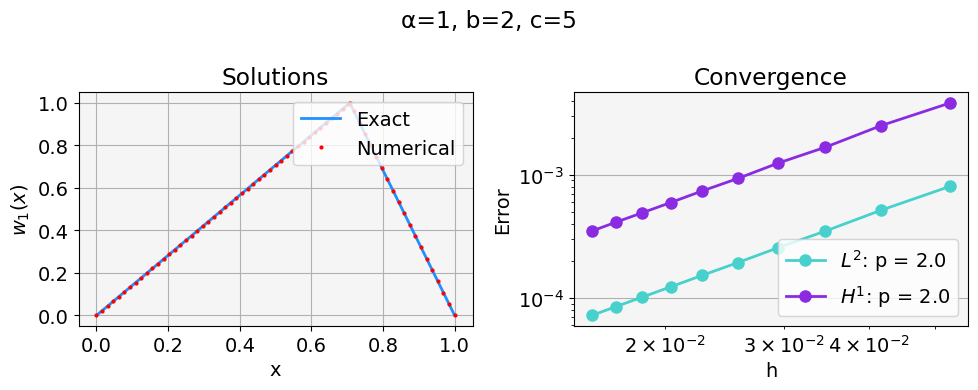

,h,Error L2,Rate L2
0,0.05263,0.00080,0.00000
1,0.04167,0.00052,1.90645
2,0.03448,0.00035,2.06511
3,0.02941,0.00026,1.93938
4,0.02564,0.00019,2.03660
5,0.02273,0.00015,1.97802
6,0.02041,0.00012,1.99874
7,0.01852,0.00010,2.00807
8,0.01695,0.00009,1.97013
9,0.01562,0.00007,2.03104


In [10]:
Var = Variables(alpha=1, b=2, c=5, exSol=w1,  func=0)
convergence(Var, FEM_non_smooth_w1, sqr=True, saveas= "2d_w1", lab = "$w_1(x)$")

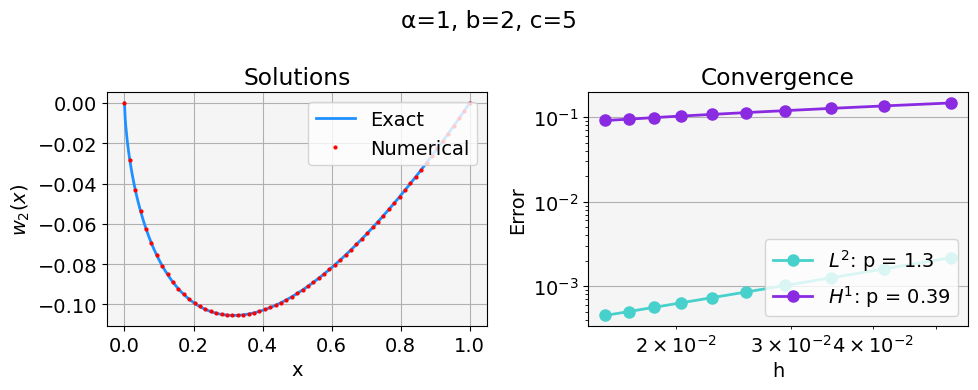

,h,Error L2,Rate L2
0,0.05263,0.00217,0.00000
1,0.04167,0.00160,1.30149
2,0.03448,0.00125,1.29840
3,0.02941,0.00102,1.29541
4,0.02564,0.00085,1.29368
5,0.02273,0.00073,1.29270
6,0.02041,0.00064,1.29208
7,0.01852,0.00056,1.29133
8,0.01695,0.00050,1.29046
9,0.01562,0.00045,1.29066


In [11]:
Var = Variables(alpha=1, b=2, c=5, exSol=w2,  func=0)
convergence(Var, FEM_non_smooth_w2, saveas= "2d_w2", lab = "$w_2(x)$")

In [12]:
def f_1(x, Var):
    return x**(-2/5)

def f_2(x, Var):
    return x**(-7/5)

def sing_ref_x(M, r):
    i = np.arange(1, M+1)
    x = np.zeros(M+1)
    x[1:] = r**(M-i)
    return x

C:\Users\krist\AppData\Local\Temp\ipykernel_23004\2801448363.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return x**(-2/5)


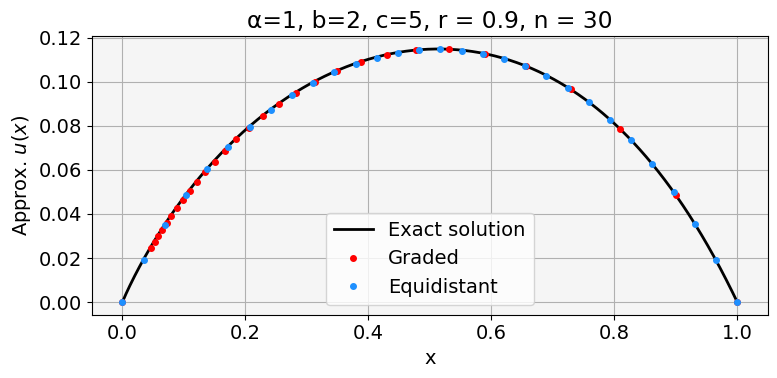

Graded


,r,Error L2
0,0.30000,0.02759
1,0.40000,0.02069
2,0.50000,0.01467
3,0.60000,0.00953
4,0.70000,0.00537
5,0.80000,0.00234
6,0.90000,0.00073
,r,Error H1
0,0.30000,0.19010
1,0.40000,0.15631


Equidistant


,n,Error,Type
0,30,0.00038,L2
1,30,0.01326,H1


In [17]:
problem = Variables(alpha=1, b=2, c=5,  func=f_1)
irreg_plots(problem, FEM, sing_ref_x, 30, saveas="2f_f1")

C:\Users\krist\AppData\Local\Temp\ipykernel_23004\2801448363.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  return x**(-7/5)


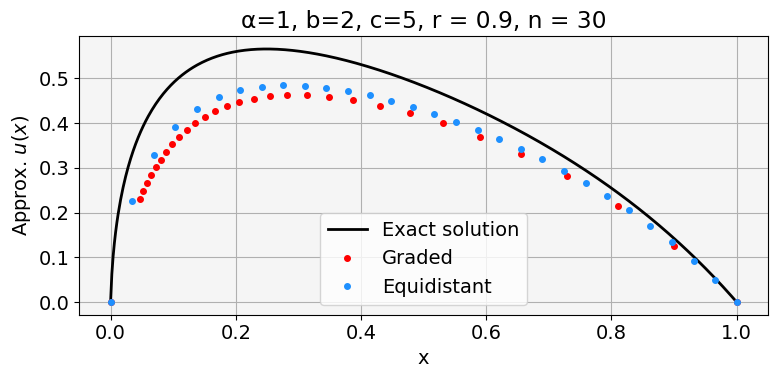

Graded


,r,Error L2
0,0.30000,0.12005
1,0.40000,0.07909
2,0.50000,0.05374
3,0.60000,0.03675
4,0.70000,0.02432
5,0.80000,0.00681
6,0.90000,0.08391
,r,Error H1
0,0.30000,1.27486
1,0.40000,0.95051


Equidistant


,n,Error,Type
0,30,0.06517,L2
1,30,1.34016,H1


In [16]:
problem = Variables(alpha=1, b=2, c=5,  func=f_2)
irreg_plots(problem, FEM, sing_ref_x, 30, saveas="2f_f2")